
Start time is:  2020-03-18 18:01:54.383960
events num is: 2500
threshold is: 0.1
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 0.3020408163265306
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 0.5040816326530613
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 0.7061224489795919
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 0.9081632653061225
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 1.1102040816326533
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 1.3122448979591839
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 1.5142857142857145
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 1.716326530612245
mean: -3.58223551692406
mean after outlier del: -4.909447588724348
threshold is: 1.9183673469387756
mean: -3.5822355169

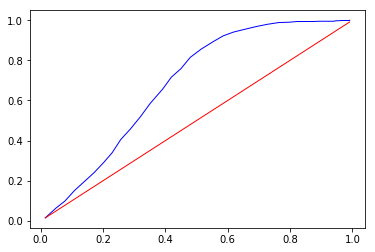

In [5]:
import numpy as np
import argparse
import json
import sys
import os
import torch
import math
import datetime

# Internal libraries
import excitation_kernels
import hawkes_model_single


from make_data_for_samples import make_data #多个样本数据
from make_data_for_samples import make_data_all_expect #取其他用户的前50个样本作为入侵者
from make_data_for_estimate import make_estimate_data     #单个样本数据

import numpy as np
import matplotlib.pyplot as plt

global result

def make_object(module, name, args):
    return getattr(module, name)(**args)

param_dict_exitation = {'exitation':{'name': 'ExponentialKernel', 'args': {'decay':1.0, 'cut_off': 1000.0}}}

#求正样本的情况
def decision_fun_1(mu,W, new_events, M ,param_dict, nu, sigma, threshold):
    events_num = len(new_events)
    dim = len(new_events[0])
    n_params = dim * (M * dim + 1)
    #3倍上界
    up =  math.exp(nu) * (math.exp(sigma))**3
    #3倍下界
    down = math.exp(nu) / (math.exp(sigma))**3    
    
    # Init Hawkes process model object
    excitation_obj = make_object(excitation_kernels, **param_dict['exitation'])
    hawkes_model_obj = hawkes_model_single.HawkesModel(excitation=excitation_obj, verbose=False)
   
    W = W.view(dim,dim,M)
    
    count = 0
    
    loglik_all=[]

    for i in range(events_num):
        loglik=[0.0,0.0]        
        hawkes_model_obj.set_data(new_events[i])
        loglik_max = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=up)
        loglik_min = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=down)
        
        loglik[0] = loglik_min.item()
        loglik[1] = loglik_max.item()
        
        if math.isnan(loglik[0]):
            if i ==0:
                loglik[0] = loglik[1]
            else:
                loglik[0] = loglik_all[i-1][0]
        if math.isnan(loglik[1]):
            if i ==0 :     #处理s032第一个就出现nan的情况
                loglik[1] = loglik[0]
            else:
                loglik[1] = loglik_all[i-1][1]
        
        loglik_all.append(loglik)
        
    loglik_list = sum(loglik_all,[])
    #print(loglik_list)
    
    mean = np.mean(loglik_list)
    print('mean:',mean)
    
    loglik_list_sort =  sorted(loglik_list)     
    
    mean = np.mean(loglik_list_sort[19:380])
    print('mean after outlier del:',mean)
    
    distance = list( map(lambda x: abs(x - mean), loglik_list) )
    
    distance_array = np.array(distance)
    #距离大于threshold的正样本个数
    out_num = np.sum((distance_array > threshold))  
    
    return mean,out_num

#求所有样本的情况
def decision_fun_2(mu,W, new_events, M ,param_dict, nu, sigma,threshold, mean):
    events_num = len(new_events)
    dim = len(new_events[0])
    n_params = dim * (M * dim + 1)
    #3倍上界
    up =  math.exp(nu) * (math.exp(sigma))**3
    #3倍下界
    down = math.exp(nu) / (math.exp(sigma))**3    
    
    # Init Hawkes process model object
    excitation_obj = make_object(excitation_kernels, **param_dict['exitation'])
    hawkes_model_obj = hawkes_model_single.HawkesModel(excitation=excitation_obj, verbose=False)
   
    W = W.view(dim,dim,M)
    
    count = 0
    
    loglik_all=[]

    for i in range(events_num):
        loglik=[0.0,0.0]        
        hawkes_model_obj.set_data(new_events[i])
        loglik_max = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=up)
        loglik_min = hawkes_model_obj.log_likelihood(mu,W,epsilon_noise=down)
        
        loglik[0] = loglik_min.item()
        loglik[1] = loglik_max.item()
        
        if math.isnan(loglik[0]):
            if i ==0:
                loglik[0] = loglik[1]
            else:
                loglik[0] = loglik_all[i-1][0]
        if math.isnan(loglik[1]):
            if i == 0 :     #处理s032第一个就出现nan的情况
                loglik[1] = loglik[0]
            else:
                loglik[1] = loglik_all[i-1][1]
            
        loglik_all.append(loglik)
        
    loglik_list = sum(loglik_all,[])
  
    distance = list( map(lambda x: abs(x - mean), loglik_list) )
    
    distance_array = np.array(distance)
    #距离大于threshold的正样本个数
    out_num = np.sum((distance_array > threshold))  
    
    return out_num

def estimate(exp_dir, param_filename, stdout=None, stderr=None):
    if stdout is not None:
        sys.stdout = open(stdout, 'w')
    if stderr is not None:
        sys.stderr = open(stderr, 'w')
    print('\nStart time is: ', datetime.datetime.today())
   
    data_fileName = "./data/DSL-StrongPasswordData.xls"
    
    user = 's052'
    
    if user == 's036':
        events = make_data('s036',12000,12400,data_fileName)
    if user == 's047':
        events = make_data('s047',16000,16400,data_fileName)
    if user == 's052':
        events = make_data('s052',18000,18400,data_fileName)
    if user == 's032':
        events = make_data('s032',10400,10800,data_fileName)
    if user == 's010':
        events = make_data('s010',2400,2800,data_fileName)
    if user == 's008':
        events = make_data('s008',2000,2400,data_fileName)
    if user == 's007':
        events = make_data('s007',1600,2000,data_fileName)
    if user == 's005':
        events = make_data('s005',1200,1600,data_fileName)
    if user == 's004':
        events = make_data('s004',800,1200,data_fileName)
    if user == 's003':
        events = make_data('s003',400,800,data_fileName)
    if user == 's002':
        events = make_data('s002',0,400,data_fileName)
        
    n_jumps_per_dim = list(map(len, events[0]))
    n_nodes = len(events[0])
    #print('Number of jumps:', len(events)*sum(n_jumps_per_dim))
    #print('per node:', n_jumps_per_dim)
    
    events = torch.tensor(events, dtype=torch.float32)
    
    #print('\nestimating')
    #print('=========')

    param_filename = os.path.join(exp_dir, param_filename)
    if not os.path.exists(param_filename):
        raise FileNotFoundError(
            'Input file `{:s}` not found.'.format(param_filename))
    with open(param_filename, 'r') as param_file:
        param_dict = json.load(param_file)
        
    mu = torch.tensor(param_dict['vi_exp']['mu'],dtype=torch.float32)
    W = torch.tensor(param_dict['vi_exp']['adjacency'],dtype=torch.float32)
    
    #W = W.view(n_nodes,n_nodes)
    
    #print('mu:',mu)
    #print('W:',W)
    
    #nu = -1.3839905543829933
    #sigma = 0.2960047784292162
    
    nu = param_dict['vi_exp']['nu']
    sigma = param_dict['vi_exp']['sigma']
    
    #threshold_range = np.linspace(1,6,20)
    threshold_range = np.linspace(0.1,10,50)
    FN = [0]*len(threshold_range)
    TP = [0]*len(threshold_range)
    FP = [0]*len(threshold_range)
    TN = [0]*len(threshold_range)
    
    false_alarm_rate = [0.0]*len(threshold_range)
    miss_rate = [0.0]*len(threshold_range)
    recall = [0.0]*len(threshold_range)
    precision = [0.0]*len(threshold_range)
    #hit_rate = [0.0]*len(threshold_range)
    
    all_events = make_data_all_expect(data_fileName,user)
    print('events num is:',len(all_events))
    
    all_events = torch.tensor(all_events, dtype=torch.float32)
    
    for i,threshold in enumerate(threshold_range):
        print('threshold is:',threshold)
        
        mean,out_num = decision_fun_1(mu=mu, W=W, new_events=events, M=1 ,param_dict=param_dict_exitation,nu=nu, sigma=sigma,threshold=threshold)
        out_num_all = decision_fun_2(mu=mu, W=W, new_events=all_events, M=1 ,param_dict=param_dict_exitation,nu=nu, sigma=sigma,
                                     threshold=threshold, mean=mean)
        
        FN[i] = out_num
        TP[i] = 800-out_num                         #400*2-out_num
        FP[i] = 5000 -  out_num_all                 #2500*2 - out_num_all
        TN[i] = out_num_all
        
        false_alarm_rate[i] = FP[i]/(FP[i]+TN[i])
        miss_rate[i] = FN[i]/(TP[i]+FN[i])
        recall[i] = TP[i]/(TP[i]+FN[i])
        precision[i] = TP[i]/(TP[i]+FP[i])    
    
    print('FN is:', FN)
    print('TP is:', TP)
    print('FP is:', FP)
    print('TN is:', TN)
    
    print('false_alarm_rate is:',false_alarm_rate)
    print('miss_rate is:',miss_rate)
    
    #画false-alarm/hit rate ROC图
    hit_rate = list( map(lambda x: 1 - x, miss_rate) )
    print('hit_rate is:',hit_rate)
    plt.plot(false_alarm_rate,hit_rate,color="blue",linewidth=1)
    plt.plot(false_alarm_rate,false_alarm_rate,color="red",linewidth=1)
  
    print('\n\nFinished.')
    print('\nEnd time is: ', datetime.datetime.today())


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-d', '--dir', dest='dir', type=str,
                        #required=True, help="Working directory")
                        required=False, default=".")
    parser.add_argument('-p', '--params', dest='param_filename', type=str,
                        required=False, default='params.json',
                        help="Input parameter file (JSON)")
    args = parser.parse_known_args()[0]
    estimate ('.','./result/2/last_result/penalty10+decay1.0+s052_18000-18200.json')